# Big Data for Health (CSE6250) 

Goal: Using Lightgbm model to predict sepsis onset using MIMIC III Data

Author: Zhensheng Wang
         
Created: 11/13/2021

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score, f1_score
from tableone import TableOne
import lightgbm as lgbm
from hyperopt import fmin, hp, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from tableone import TableOne
import matplotlib.pyplot as plt
import warnings
from Python.model_data import model_data
from Python.utils import classification_metrics, plot_roc, plot_prc
warnings.filterwarnings('ignore')
# from imblearn.over_sampling import RandomOverSampler

import os, gc
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= os.path.join(os.getcwd(), "bdfh.json")
# from google.cloud import bigquery
# bqclient = bigquery.Client()

## Parameter setting

In [2]:
DATA_DIR = 'data_ultimate_final'
SEED = 42
MAX_EVAL = 50
TEST_SIZE = 0.1

## Load Data

In [6]:

case_labs = pd.read_csv(os.path.join(DATA_DIR, 'case_48h_labs_ex3h.csv'))
case_vitals = pd.read_csv(os.path.join(DATA_DIR, 'case_48h_vitals_ex3h.csv'))
case_static = pd.read_csv(os.path.join(DATA_DIR, 'static_variables_cases_ex3h.csv'))

control_labs = pd.read_csv(os.path.join(DATA_DIR, 'control_48h_labs_ex3h.csv'))
control_vitals = pd.read_csv(os.path.join(DATA_DIR, 'control_48h_vitals_ex3h.csv'))
control_static = pd.read_csv(os.path.join(DATA_DIR, 'static_variables_controls_ex3h.csv'))

# df_train, df_test = model_data(model_type="LGBM", test_size=.2)


## Helper function


In [ ]:
def race_recode(df):
    cond_white = df['ethnicity'].str.contains('WHITE')
    cond_black = df['ethnicity'].str.contains('BLACK')
    cond_asian = df['ethnicity'].str.contains('ASIAN')
    cond_hispa = df['ethnicity'].str.contains('HISPANIC')

    df.loc[cond_white, 'ethnicity'] = 'WHITE'
    df.loc[cond_black, 'ethnicity'] = 'BLACK'
    df.loc[cond_asian, 'ethnicity'] = 'ASIAN'
    df.loc[cond_hispa, 'ethnicity'] = 'HISPANIC'
    df.loc[~(cond_white | cond_black | cond_asian | cond_hispa), 'ethnicity'] = 'OTHER'
    
    df['ethnicity'] = df['ethnicity'].apply(lambda x: x[0] + x[1:].lower())
    return df

## Table1

In [ ]:

t1_case = case_static.sort_values(['subject_id', 'admission_age']).drop_duplicates('subject_id')[['gender', 'ethnicity', 'admission_age', 'subject_id']]
t1_case = t1_case[t1_case.subject_id.isin(case_vitals.subject_id) & t1_case.subject_id.isin(case_labs.subject_id)]
t1_case.loc[:, 'gender'] = t1_case['gender'].apply(lambda x: 'Female' if x == 'F' else 'Male')
t1_case = race_recode(t1_case)
t1_case['Sepsis'] = 'Yes'

t1_control = control_static.sort_values(['subject_id', 'admission_age']).drop_duplicates('subject_id')[['gender', 'ethnicity', 'admission_age', 'subject_id']]
t1_control = t1_control[t1_control.subject_id.isin(control_vitals.subject_id) & t1_control.subject_id.isin(control_labs.subject_id)]

t1_control.loc[:, 'gender'] = t1_control['gender'].apply(lambda x: 'Female' if x == 'F' else 'Male')
t1_control = race_recode(t1_control)
t1_control['Sepsis'] = 'No'

t1 = pd.concat((t1_case, t1_control), ignore_index=True).drop_duplicates('subject_id')

order = {
    'ETHNICITY': ['White', 'Black', 'Hispanic', 'Asian', 'Other']
}

label = {
    'admission_age': 'Age (yrs) at first admission',
    # 'los': 'Length of stay (days)',
    'ethnicity': 'Race/Ethnicity',
    # 'MARITAL_STATUS': 'Marital status',
    'gender': 'Gender',
    # 'INSURANCE': 'Insurance'
}

t1_pivot = TableOne(
    t1, 
    columns=['gender', 'ethnicity', 'admission_age'], 
    categorical=['gender', 'ethnicity'],
    nonnormal = ['admission_age'],  
    groupby = 'Sepsis', 
    limit = 6, 
    order = order,
    pval = True,
    missing = False,
    rename = label)

In [ ]:
t1_pivot.to_csv('t1_pivot.csv')
t1_pivot

## Clean data

In [ ]:
# case_labs = case_labs.drop(columns=['chart_time', 'icustay_id', 'sepsis_onset', 'hr_feature'])
# apply_dict = {col: ['mean', 'median', 'std'] for col in case_labs.columns if col != 'subject_id'}
# case_labs = case_labs.groupby('subject_id').agg(apply_dict)
# # case_labs = case_labs.fillna(case_labs.median())
# case_labs.columns = ['_'.join(col) for col in case_labs.columns]

# case_static = case_static[['gender', 'ethnicity', 'admission_age', 'subject_id']]
# case_static['label'] = 1
# case_static = race_recode(case_static)
# case_static['ethnicity'] = LabelEncoder().fit_transform(case_static['ethnicity'])
# case_static['gender'] = LabelEncoder().fit_transform(case_static['gender'])

# case_vitals = case_vitals.drop(columns=['chart_time', 'icustay_id', 'sepsis_onset', 'hr_feature'])
# apply_dict = {col: ['mean', 'median', 'std'] for col in case_vitals.columns if col != 'subject_id'}
# case_vitals = case_vitals.groupby('subject_id').agg(apply_dict)
# # case_vitals = case_vitals.fillna(case_vitals.median())
# case_vitals.columns = ['_'.join(col) for col in case_vitals.columns]

# case_all = case_static.merge(case_labs, on='subject_id').merge(case_vitals, on='subject_id')


# control_labs = control_labs.drop(columns=['chart_time', 'icustay_id', 'control_onset_time', 'hr_feature'])
# apply_dict = {col: ['mean', 'median', 'std'] for col in control_labs.columns if col != 'subject_id'}
# control_labs = control_labs.groupby('subject_id').agg(apply_dict)
# # control_labs = control_labs.fillna(control_labs.median())
# control_labs.columns = ['_'.join(col) for col in control_labs.columns]

# control_static = control_static[['gender', 'ethnicity', 'admission_age', 'subject_id']]
# control_static['label'] = 0
# control_static = race_recode(control_static)
# control_static['ethnicity'] = LabelEncoder().fit_transform(control_static['ethnicity'])
# control_static['gender'] = LabelEncoder().fit_transform(control_static['gender'])

# control_vitals = control_vitals.drop(columns=['chart_time', 'icustay_id', 'control_onset_time', 'hr_feature'])
# apply_dict = {col: ['mean', 'median', 'std'] for col in control_vitals.columns if col != 'subject_id'}
# control_vitals = control_vitals.groupby('subject_id').agg(apply_dict)
# # control_vitals = control_vitals.fillna(control_vitals.median())
# control_vitals.columns = ['_'.join(col) for col in control_vitals.columns]

# control_all = control_static.merge(control_labs, on='subject_id').merge(control_vitals, on='subject_id')


# case_control_all = pd.concat((case_all, control_all), ignore_index=True).sample(frac=1).reset_index(drop=True)

# cols_delete = [x for x in case_control_all.columns if x in ['subject_id', 'label', 'icustay_id'] or x.startswith('Unnamed')]
# X, y = case_control_all.drop(columns=cols_delete), case_control_all.label

## Train-test split

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=TEST_SIZE)

# X_train = MinMaxScaler().fit_transform(X_train)
# X_test = MinMaxScaler().fit_transform(X_test)

# print(f"Number of features included: {X.shape[1]}")
# print(f"Number of observations: {X.shape[0]}")
# print(y.value_counts())

In [3]:
df_train, df_test = model_data('LGBM', path = DATA_DIR, test_size=0.1)

X_train, y_train = df_train.drop(columns=['label', 'icustay_id']), df_train['label'].values
X_test, y_test = df_test.drop(columns=['label', 'icustay_id']), df_test['label'].values

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Train/Test data size: 4885/543


In [4]:
print(f"Number of features included: {df_train.shape[1]}")
print(f"Number of observations: {df_train.shape[0] + df_test.shape[0]}")
print(pd.concat((df_train, df_test))['label'].value_counts())

Number of features included: 273
Number of observations: 5428
0    4798
1     630
Name: label, dtype: int64


## Lightgbm CV

In [ ]:
# def lgb_f1_score(y_hat, data):
#     y_true = data.get_label()
#     y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
#     return 'f1', f1_score(y_true, y_hat), True

In [5]:
lgbm_param = {
    # 'model': {
        'num_leaves': scope.int(hp.quniform('num_leaves', 2, 21, 1)), # hp.choice('num_leaves', np.arange(2, 21)),
        'learning_rate': hp.uniform('learning_rate', 0.005, 0.2),
        'colsample_bytree': hp.uniform('feature_fraction', 0.1, 1.0),
        'max_depth': scope.int(hp.quniform('max_depth', 2, 11, 1)), #hp.choice('max_depth', np.arange(2, 11)),
        'objective': 'binary',    
        'verbose': -1,    
        'metric': 'auc'
    # },
    # 'pos_weight': scope.int(hp.quniform('pos_weight', 1, 11, 1)),

        # 'boosting_type': 'dart',
        # 'metric': 'logloss',
        # 
        # 'device_type': 'gpu'
}

def f_lgbm(params):
    tr_data = lgbm.Dataset(X_train, y_train)
    res = lgbm.cv(
        params, 
        tr_data, 
        num_boost_round=1000, 
        early_stopping_rounds=100, 
        seed=SEED, 
        return_cvbooster=True,
    )
    # skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
    # score = 0
    # boosters = []
    # for i, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    #     model = lgbm.LGBMClassifier(
    #         **params['model'], 
    #         num_iterations=1000,
    #         early_stopping_round=100,
    #         class_weight = {0:1, 1:params['pos_weight']},
    #         verbose = -1
    #     )
    #     model.fit(
    #         X_train[tr_idx], y_train[tr_idx], 
    #         eval_set=(X_train[val_idx], y_train[val_idx]), 
    #         eval_metric='auc',
    #         verbose = -1
    #     )
    #     preds = model.predict_proba(X_train[val_idx])[:, 1]
    #     score += roc_auc_score(y_train[val_idx], preds) / 5
    #     boosters.append(model)

    return {
        # 'loss': -round(score, 5), 
        'loss': -np.mean(res['auc-mean']).round(5), 
        'status': STATUS_OK,
        'boosters': res['cvbooster'].boosters, 
        'auc-mean': res['auc-mean'],
        'auc-std': res['auc-stdv']
    }

In [6]:
trials = Trials()
lgbm_best = fmin(f_lgbm, lgbm_param, algo=tpe.suggest, max_evals=MAX_EVAL, trials=trials, rstate=np.random.RandomState(SEED))

100%|██████████| 50/50 [00:47<00:00,  1.06trial/s, best loss: -0.77971]


## Test data prediction

<!-- 20% test data
- validation set = 0.763
- test set = 0.734

10% test data
- validation set = 0.774
- test set = 0.759 -->

In [7]:
preds = np.zeros_like(y_test, dtype=np.float32)
for booster in trials.best_trial['result']['boosters']:
    preds += booster.predict(X_test) / 5
print(f"Test AUC: {roc_auc_score(y_test, preds):.5f}")

Test AUC: 0.81475


## AUC Curve

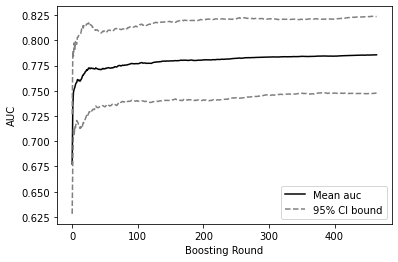

In [8]:
train_auc_df = pd.DataFrame(dict(auc =trials.best_trial['result']['auc-mean'], std=trials.best_trial['result']['auc-std']))
train_auc_df['auc_l'] = train_auc_df['auc'] - 1.96 * train_auc_df['std']
train_auc_df['auc_h'] = train_auc_df['auc'] + 1.96 * train_auc_df['std']

plt.plot(train_auc_df['auc'], 'k-', label='Mean auc')
plt.plot(train_auc_df['auc_l'], '--', color='gray', label='95% CI bound')
plt.plot(train_auc_df['auc_h'], '--', color='gray')
plt.xlabel('Boosting Round')
plt.ylabel('AUC')
plt.legend()
# plt.title('AUC Curve on 5-fold cross validation lightgbm model')
plt.savefig('lightgbm-auc.jpg')

## Feature importance

In [9]:
# dir(res['cvbooster'])
feature_imp = np.zeros((X_train.shape[1]))
for i, booster in enumerate(trials.best_trial['result']['boosters']):
    feature_imp += booster.feature_importance() / 5
    booster.save_model(f'output/lgbm_fold{i}.txt')
    

In [10]:
feature_imp = pd.DataFrame(dict(features = df_train.drop(columns=['label', 'icustay_id']).columns, feature_importance = feature_imp)). \
    sort_values('feature_importance', ascending=False, ignore_index=True).head(10)
feature_imp.to_latex('feature_imp.tex', index=False)
feature_imp

,features,feature_importance
0,MeanBP_count,144.8
1,DiaBP_max,143.2
2,PLATELET_min,141.8
3,RespRate_count,141.4
4,TempC_std,136.6
5,MeanBP_min,132.6
6,SysBP_count,123.8
7,CREATININE_mean,123.6
8,HeartRate_count,119.2
9,PLATELET_mean,114.4


In [11]:
classification_metrics("LightGBM", y_test, preds)


______________________________________________
Classifier: LightGBM
Accuracy:  0.8895
AUC:  0.8147
AUPRC:  0.4530
Precision:  1.0000
Recall:  0.0476
F1-score:  0.0909
______________________________________________



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


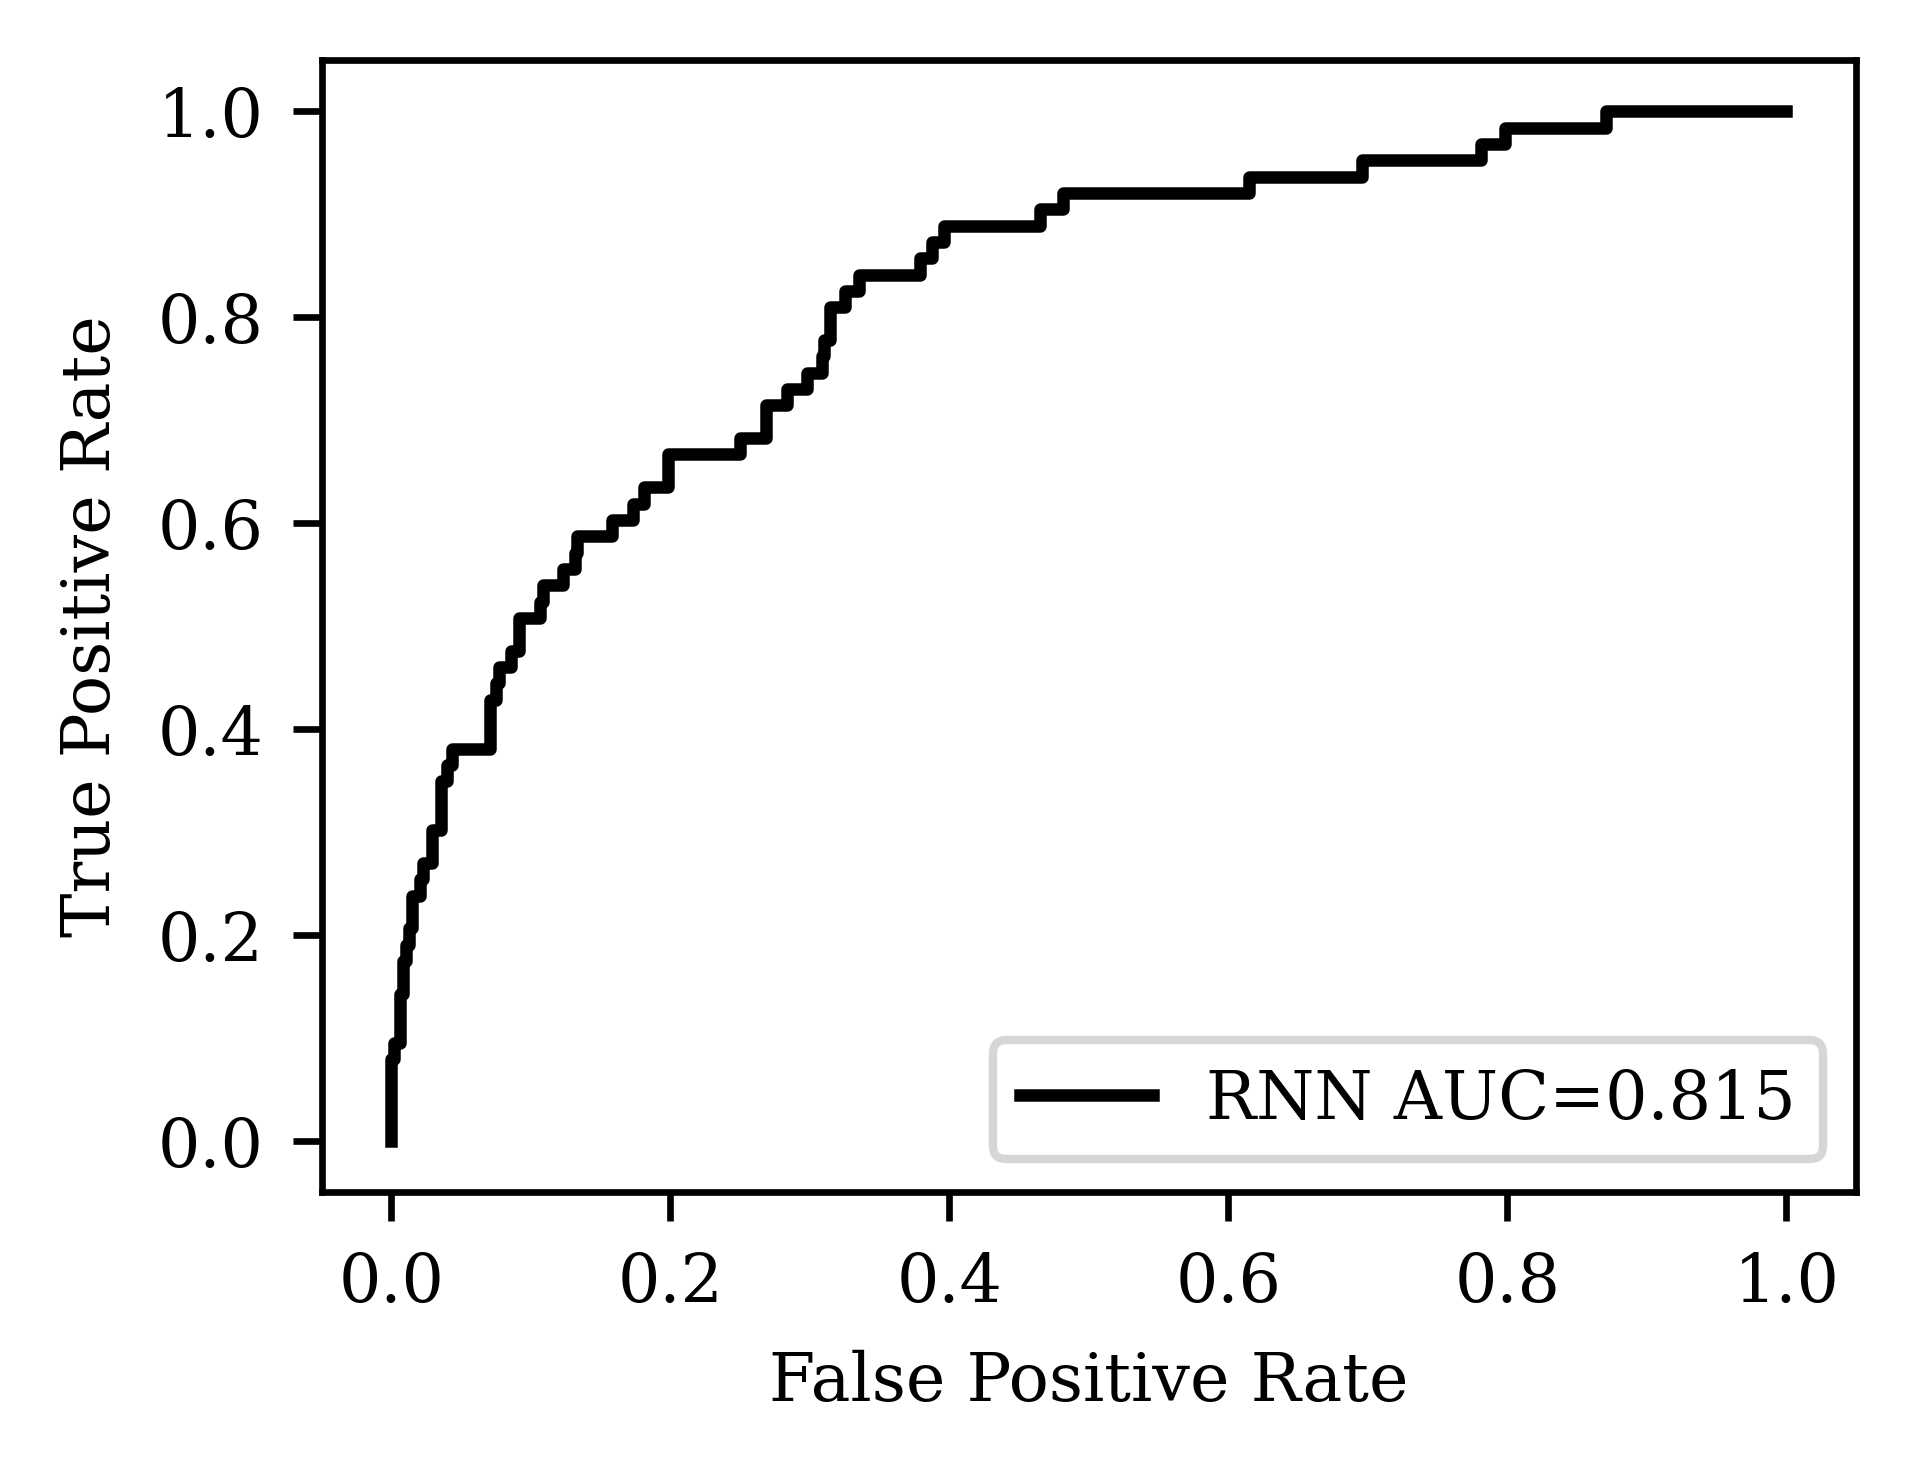

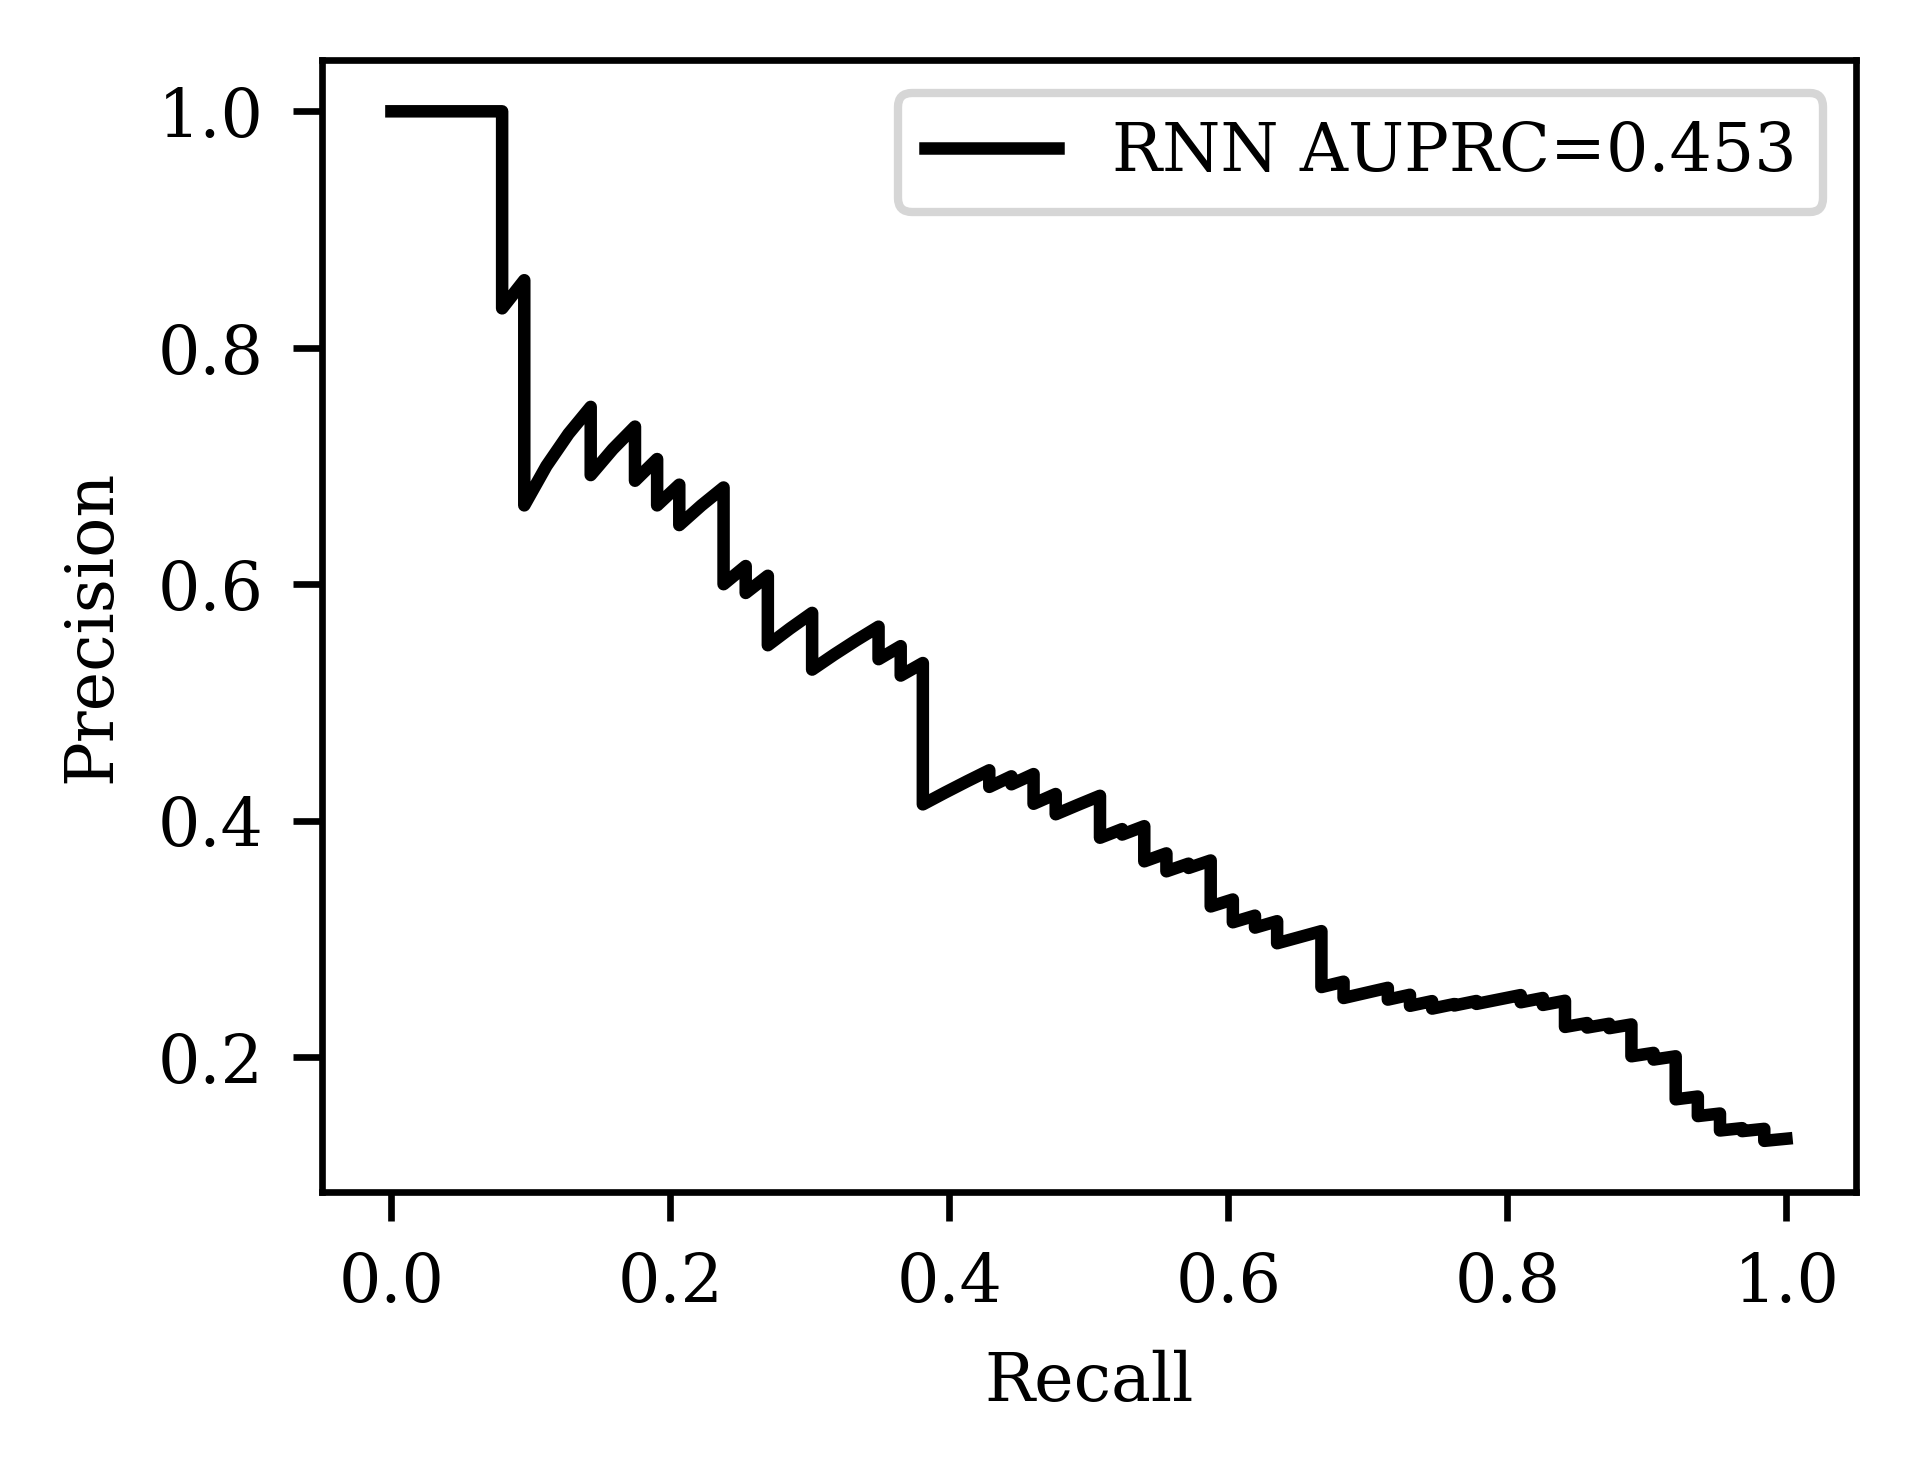

In [12]:
plot_roc(figname="output/LightGBM_roc.png", RNN="output/LightGBM_roc.csv")
plot_prc(figname="output/RNN_prc.png", RNN="output/LightGBM_prc.csv")